In [1]:
#Load packages
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)

RFC_METRIC = 'gini'  
NUM_ESTIMATORS = 100 
NO_JOBS = 4 


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20
TEST_SIZE = 0.20 

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 
EARLY_STOP = 50 
OPT_ROUNDS = 1000  
VERBOSE_EVAL = 50 

In [2]:
#Read the data
data_df = pd.read_csv("Fraud.csv")

In [3]:
#Check the data 
print("Fraud Detection data -  rows:", data_df.shape[0]," columns:", data_df.shape[1])

Fraud Detection data -  rows: 6362620  columns: 11


In [4]:
#Glimple of data
data_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
data_df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [6]:
data_df.rename(columns={"step":"Time"})

,Time,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [10]:
#Check for missing data
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)

pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
#Check for data unbalance
temp = data_df["isFraud"].value_counts()
df = pd.DataFrame({'isFraud': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['isFraud'],y = df['values'],
    name="Fraud Class-data unbalance(Not fraud=0, Fraud=1)",
    marker=dict(color="Red"),
    text=df['values'])

data = [trace]
layout = dict(title = 'Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'isFraud', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600)

fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

In [12]:
#Data exploration
class_0 = data_df.loc[data_df['isFraud'] == 0]["step"]
class_1 = data_df.loc[data_df['isFraud'] == 1]["step"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Transactions Time Density Plot', xaxis=dict(title='Time[hour]'))
iplot(fig, filename='dist_only')

In [13]:
#Time distribution of Fraud transactions and aggregated values of transaction count and amount per hour
data_df['Hour'] = data_df['step']

tmp = data_df.groupby(['Hour', 'isFraud'])['amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'isFraud', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,isFraud,Min,Max,Transactions,Sum,Mean,Median,Var
0,1,0,6.42,3776389.09,2692,2.816889e+08,104639.277169,10260.550,5.864581e+10
1,1,1,181.00,1277212.77,16,3.740247e+06,233765.438125,30067.545,1.796084e+11
2,2,0,29.26,2474181.78,1006,8.173501e+07,81247.526382,10383.745,3.423103e+10
3,2,1,14949.84,1096187.24,8,4.186592e+06,523324.060000,491079.580,2.957482e+11
4,3,0,35.20,2837270.65,548,4.322705e+07,78881.481168,14091.980,3.880025e+10


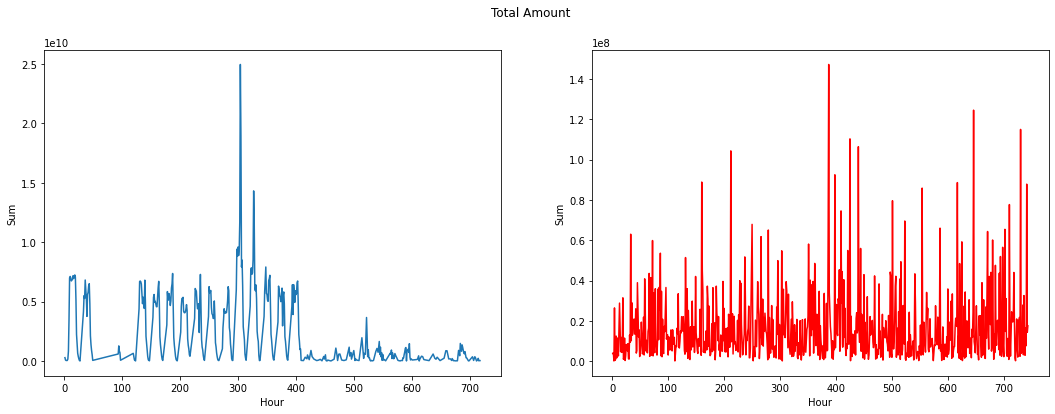

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.isFraud==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.isFraud==1], color="red")
plt.suptitle("Total Amount")
plt.show();

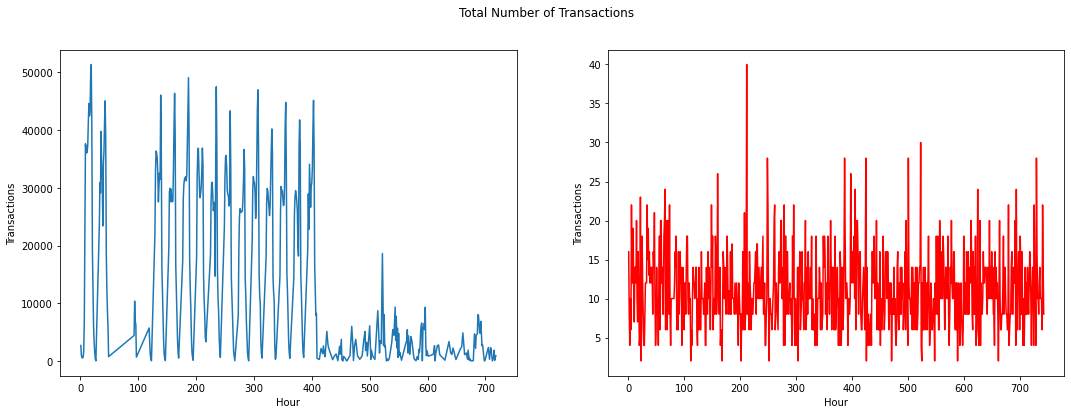

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.isFraud==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.isFraud==1], color="red")
plt.suptitle("Total Number of Transactions")
plt.show();

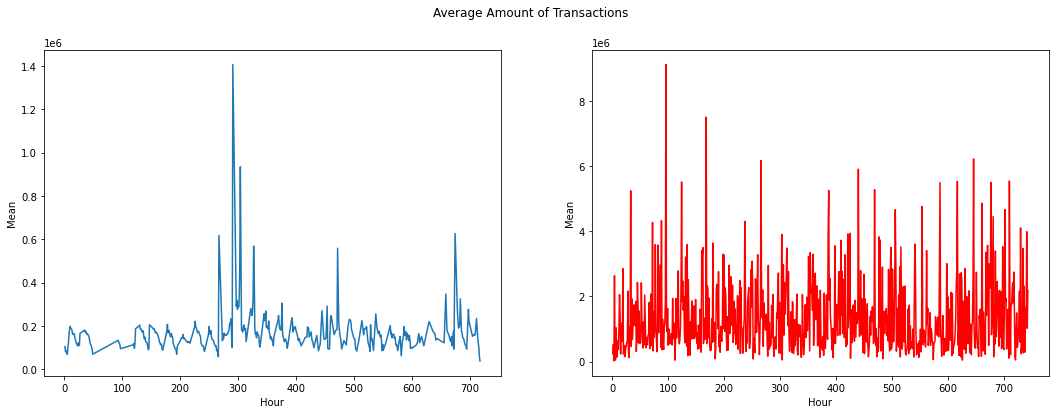

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.isFraud==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.isFraud==1], color="red")
plt.suptitle("Average Amount of Transactions")
plt.show();

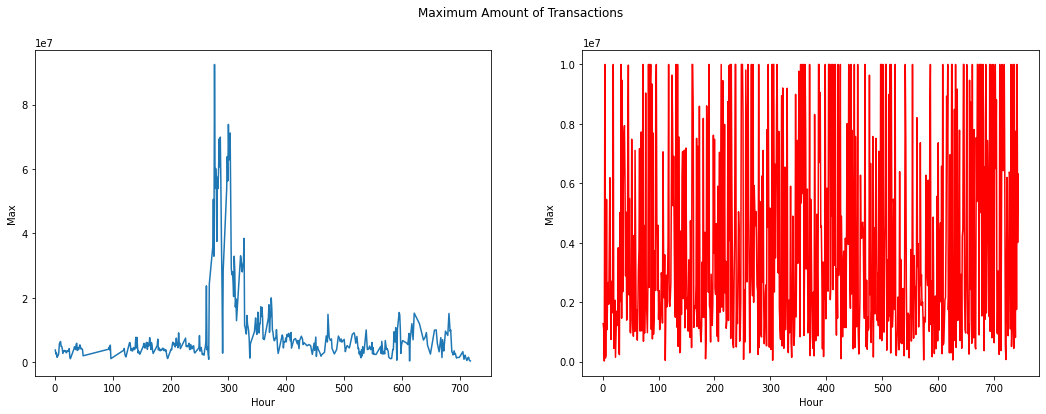

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.isFraud==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.isFraud==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
plt.show();

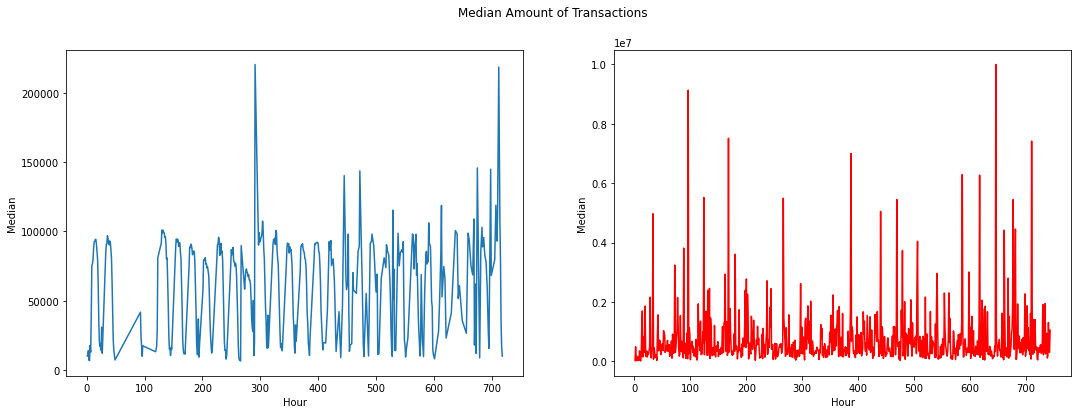

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=df.loc[df.isFraud==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=df.loc[df.isFraud==1], color="red")
plt.suptitle("Median Amount of Transactions")
plt.show();

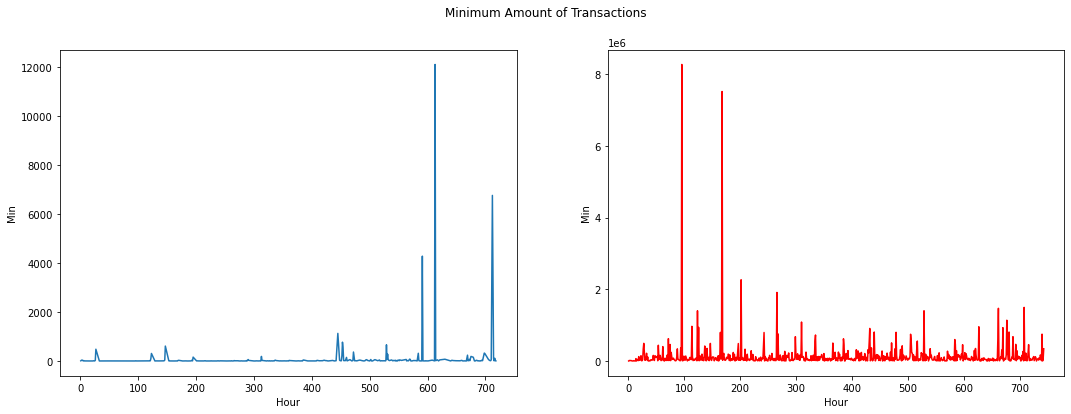

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.isFraud==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.isFraud==1], color="red")
plt.suptitle("Minimum Amount of Transactions")
plt.show();

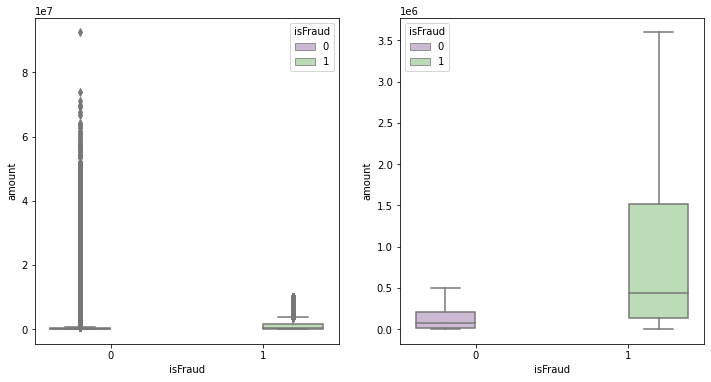

In [20]:
#Transaction amount
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="isFraud", y="amount", hue="isFraud",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFraud", y="amount", hue="isFraud",data=data_df, palette="PRGn",showfliers=False)
plt.show();

In [21]:
tmp = data_df[['amount','isFraud']].copy()
class_0 = tmp.loc[tmp['isFraud'] == 0]['amount']
class_1 = tmp.loc[tmp['isFraud'] == 1]['amount']

class_0.describe()

count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64

In [22]:
class_1.describe()

count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

In [23]:
#Plotting fraudulent transaction(amount) against time. 
#Time is in hours from the start of the time period(30 Days stimulation)
fraud = data_df.loc[data_df['isFraud'] == 1]

trace = go.Scatter(
    x = fraud['step'],
    y = fraud['amount'],
    name="amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'Time [Hour]', showticklabels=True), 
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

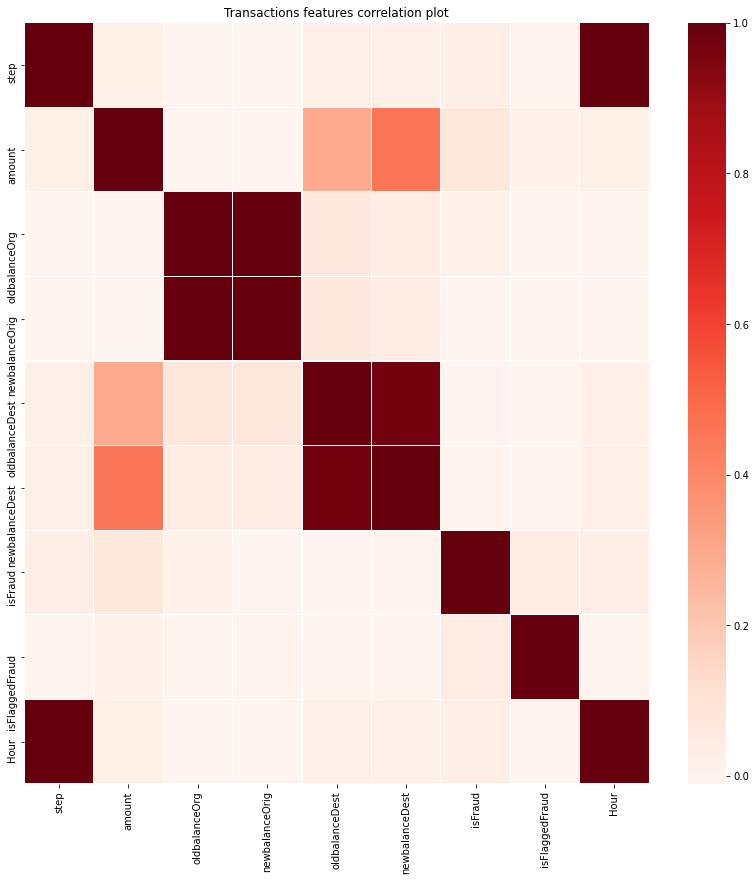

In [24]:
#Feature correlation
plt.figure(figsize = (14,14))
plt.title('Transactions features correlation plot')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

In [25]:
#Predictive model
target = 'isFraud'
predictors = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',\
              'newbalanceDest', 'isFlaggedFraud']

In [26]:
#Split for training, validation and testing
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [27]:
#RandomForestClassifier
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [28]:
#train
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

In [29]:
#predict
preds = clf.predict(valid_df[predictors])

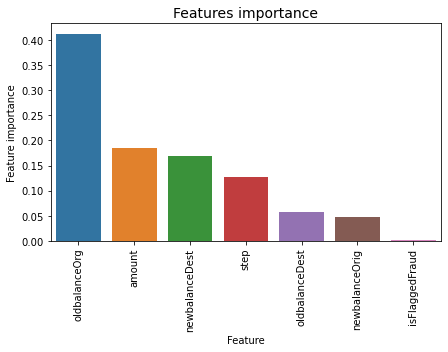

In [30]:
#Feature importance
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

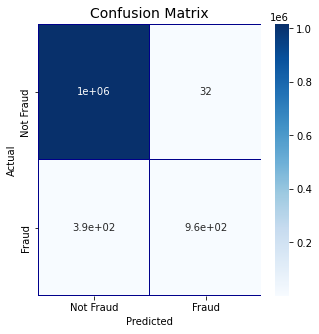

In [31]:
#Confusion matrix
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [32]:
#Area under the curve
roc_auc_score(valid_df[target].values, preds)

0.8551105625571874

In [ ]:
#The ROC-AUC score obtained with RandomForrestClassifier is 0.8551